## CGLMP Cuts Analysis

This is the truth-level analysis of Bell Study. It includes two parts 'kinematics' and 'CGLMP' analysis.

> Author : Y.Y. Gary Peng  
> Istitute: National Tsing Hua University, Taiwan and ATLAS experiment, CERN  
> License : MIT  
> Data : June 17, 2023  
> Email : yuan-yen.peng@cern.ch

Version : 5.0


In [1]:
%reset -f

In [2]:

import os
import gc
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from numba import njit
import mplhep as hep
import matplotlib.pyplot as plt
import plot.AtlasPlot as atlas
# import uproot
# import ROOT

In [3]:

def get_files_names(path):
    files_name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            files_name.append(os.path.join(dirname, filename))
    return files_name

path = "./truth/"
files_name = get_files_names(path)
print(files_name)

['./truth/CGLMP.npz', './truth/WpBoson.npz', './truth/subLeadLepton.npz', './truth/LeptonP.npz', './truth/Higgs.npz', './truth/LeadLepton.npz', './truth/LeptonM.npz', './truth/xi_xyz.npz', './truth/WmBoson.npz', './truth/LmNu.npz', './truth/LpNu.npz', './truth/MET.npz', './truth/diLepton.npz']


In [4]:
def get_data(path):
    try:
        with np.load(path, allow_pickle=True) as f:
            data_dict = {name: f[name] for name in f.files}
            return pd.DataFrame(data_dict)
    except FileNotFoundError:
        print("File not found!")
        return pd.DataFrame()

In [5]:
files = []
files_name.sort()
for f in files_name:
    files.append(get_data(f))

In [6]:
# need to check the order of data name.
files_name

['./truth/CGLMP.npz',
 './truth/Higgs.npz',
 './truth/LeadLepton.npz',
 './truth/LeptonM.npz',
 './truth/LeptonP.npz',
 './truth/LmNu.npz',
 './truth/LpNu.npz',
 './truth/MET.npz',
 './truth/WmBoson.npz',
 './truth/WpBoson.npz',
 './truth/diLepton.npz',
 './truth/subLeadLepton.npz',
 './truth/xi_xyz.npz']

In [7]:
# need to follow the order of data name.
(
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    LmNu,
    LpNu,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
) = files
GEV=1e3

del files_name, files
gc.collect()

11

In [8]:
LeadLep.describe()

,E,px,py,pz,m,pt,eta,phi,y
count,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06
mean,1.197422e+05,-3.295308e+01,4.484009e+00,9.229026e+01,5.374694e+01,3.977950e+04,1.268671e-03,9.636687e-04,1.268426e-03
std,1.498041e+05,3.141865e+04,3.138011e+04,1.865679e+05,5.257035e+01,1.973409e+04,1.585576e+00,1.814516e+00,1.585573e+00
min,9.996190e-01,-8.960872e+05,-5.162718e+05,-3.097812e+06,5.109880e-01,3.322850e-01,-5.197643e+00,-3.141590e+00,-5.197358e+00
25%,4.267738e+04,-2.281005e+04,-2.279634e+04,-5.113060e+04,5.110000e-01,2.793740e+04,-1.134085e+00,-1.570615e+00,-1.134084e+00
50%,6.798942e+04,-4.195890e+01,2.582102e+01,5.282567e+01,1.056600e+02,3.594768e+04,1.580000e-03,1.710000e-03,1.580000e-03
75%,1.321880e+05,2.279357e+04,2.280145e+04,5.132020e+04,1.056600e+02,4.599489e+04,1.136296e+00,1.573458e+00,1.136290e+00
max,3.199309e+06,8.355692e+05,5.790039e+05,3.199011e+06,1.056600e+02,8.970521e+05,5.267880e+00,3.141587e+00,5.268055e+00


In [9]:
def plot(
    data: list,
    xlabel: str,
    label: list,
    binNum: int = 30,
    loc: int = 4,
    save=False,
    unit="None",
) -> None:
    
    mini = np.min(data[0])
    maxi = np.max(data[0])

    hp = atlas.ATLAShist(mini, maxi, binNum, "Bell", "HWW", "CutAnalysis")
    hp.set_data(data)
    hp.set_graph(
        color=["blue"],
        xlabel=xlabel,
        ylabel="Events",
        lib_name="Simulation",
        unit=unit
    )
    hp.histfill_1d(
        plottype="step",
        filename="CutAnalysis",
        legend_name=label,
        show=False,
        dump=save,
        loc=loc,
    )
    plt.close()

    return

In [10]:
def CGLMP_analysis(CutName: str="Default", Cuts: list=[], show: bool=False) -> list:
      if len(Cuts) == 0:
            data = CGLMP
            warnings.warn("No cut applied...")
            cri = np.ones(len(CGLMP), dtype=bool)
      else:
            cri = np.prod(Cuts, axis=0).astype(bool)
            data = CGLMP[cri]
      Bxy = np.average(data['Bxy'])
      Bxz = np.average(data['Bzx'])
      Byz = np.average(data['Byz'])
      I3 = np.max([Bxy, Bxz, Byz])

      if show is True:
            print(f'''# {CutName}
Bxy = {Bxy:1.3f}
Bxz = {Bxz:1.3f}
Byz = {Byz:1.3f}
-> I3 = {I3 :1.3f}\n''')
      
      return cri

In [11]:
# Cut_LeadLep > 22
# Cut_SubLeadLep > 15
# Cut_mll_1 > 10
# Cut_MET > 20

# Cut_mll_2 < 55
# DPhill < 1.8

In [12]:
def ratio(
    nu: list,
    de: list = [],
    df: pd.DataFrame = LeadLep,
    var: str = "pt",
    nu_name: str = "neumerator",
    de_name: str = "denominator",
    show: bool = False,
) -> tuple:
    Cut_nu = CGLMP_analysis(nu_name, Cuts=nu, show=show)
    Cut_de = CGLMP_analysis(de_name, Cuts=de)
    min, max = np.min(df[Cut_de][var]), np.max(df[Cut_de][var])
    nu = np.histogram(df[Cut_nu][var], bins=50, range=[min, max], density=True)
    de = np.histogram(df[Cut_de][var], bins=50, range=[min, max], density=True)
    tor = 1e-10  # evade the 0 deivision
    ratio = np.divide(nu[0] + tor, de[0] + tor)
    # print(ratio)

    return ratio[~np.isnan(ratio)], nu[1][:-1]

def kl_div(
    qk: list,
    pk: list = [],
    df: pd.DataFrame = LeadLep,
    var: str = "pt",
    qk_name: str = "neumerator",
    pk_name: str = "pknominator",
    show: bool = False,
) -> tuple:
    Cut_qk = CGLMP_analysis(qk_name, Cuts=qk, show=show)
    Cut_pk = CGLMP_analysis(pk_name, Cuts=pk)
    min, max = np.min(df[Cut_pk][var]), np.max(df[Cut_pk][var])
    qk = np.histogram(df[Cut_qk][var], bins=50, range=[min, max], density=True)
    pk = np.histogram(df[Cut_pk][var], bins=50, range=[min, max], density=True)
    entropy = stats.entropy(pk[0], qk[0])

    return entropy, qk[1][:-1]


def ratio_plot(
    ratio_data, ylabel: str = r"$p_{T}$ [GeV]", range: list = [0, 30]
) -> None:
    hep.style.use("ATLAS")
    hep.atlas.label(lumi=139, loc=0)
    plt.plot(range, ratio_data, ".--", alpha=0.9)
    plt.ylabel("ratio (after/before)")
    plt.xlabel(ylabel)
    plt.xlim(np.min(range)-0.01*np.min(range), np.max(range)+0.01*np.max(range))

    return None

def kl_plot(
    ratio_data, ylabel: str = r"$p_{T}$ [GeV]", range: list = [0, 30]
) -> None:
    hep.style.use("ATLAS")
    hep.atlas.label(lumi=139, loc=4)
    plt.plot(range, ratio_data, "o--", alpha=1)
    plt.ylabel(f"KL divergence ({ylabel})")
    plt.xlabel("Order of cuts")
    plt.xlim(np.min(range)-0.05*np.max(range), np.max(range)+0.05*np.max(range))
    plt.xticks(np.arange(np.min(range), np.max(range)+1))

    return None


# define cuts and the order of cuts
cuts = [
    [],
    [LeadLep["pt"] / GEV > 22.0],
    [LeadLep["pt"] / GEV > 22.0, SubLep["pt"] / GEV > 15.0],
    [LeadLep["pt"] / GEV > 22.0, SubLep["pt"] / GEV > 15.0, diLep["m"] / GEV > 10.0],
    [
        LeadLep["pt"] / GEV > 22.0,
        SubLep["pt"] / GEV > 15.0,
        diLep["m"] / GEV > 10.0,
        MET["pt"] / GEV > 20.0,
    ],
]
name = ["0", "1", "2", "3", "4"]

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


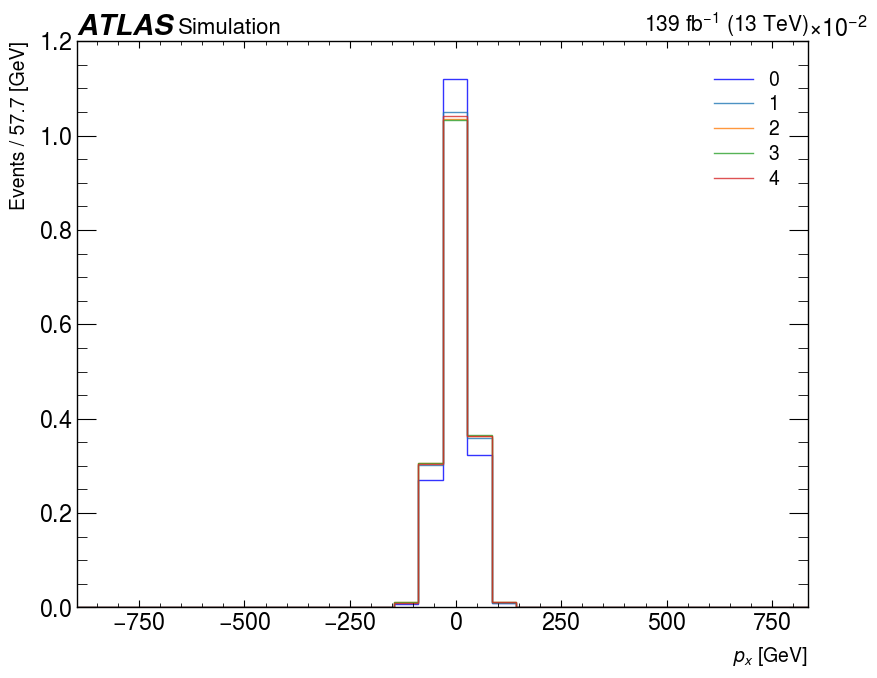

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


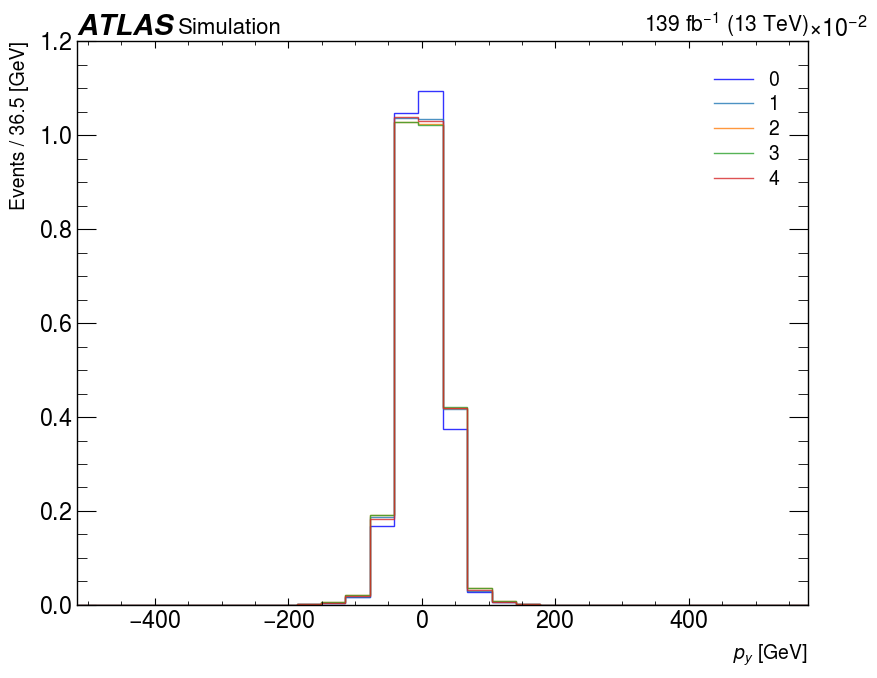

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


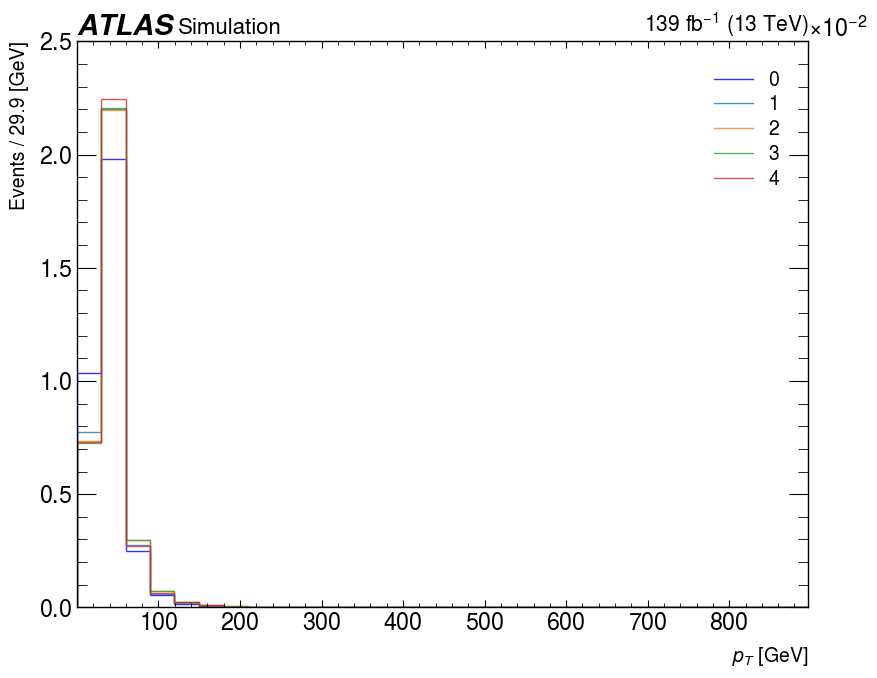

1D, Finish!


In [13]:
data = [LeadLep[CGLMP_analysis(Cuts=cuts[i])]["px"]/GEV for i in np.arange(len(cuts))]
plot(data, xlabel=r"$p_{x}$", label=name, loc=0, unit="GeV")
data = [LeadLep[CGLMP_analysis(Cuts=cuts[i])]["py"]/GEV for i in np.arange(len(cuts))]
plot(data, xlabel=r"$p_{y}$", label=name, loc=0, unit="GeV")
data = [LeadLep[CGLMP_analysis(Cuts=cuts[i])]["pt"]/GEV for i in np.arange(len(cuts))]
plot(data, xlabel=r"$p_{T}$", label=name, loc=0, unit="GeV")

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


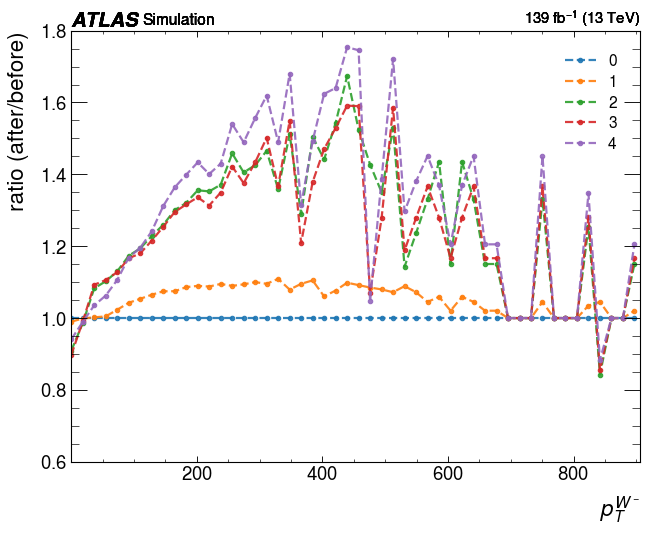

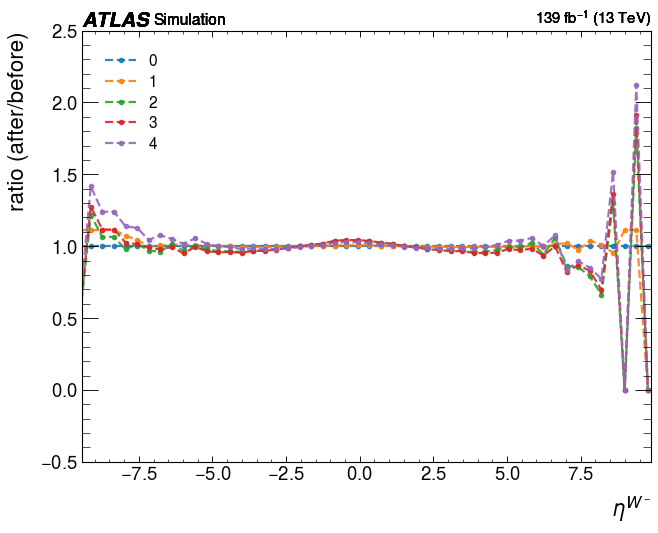

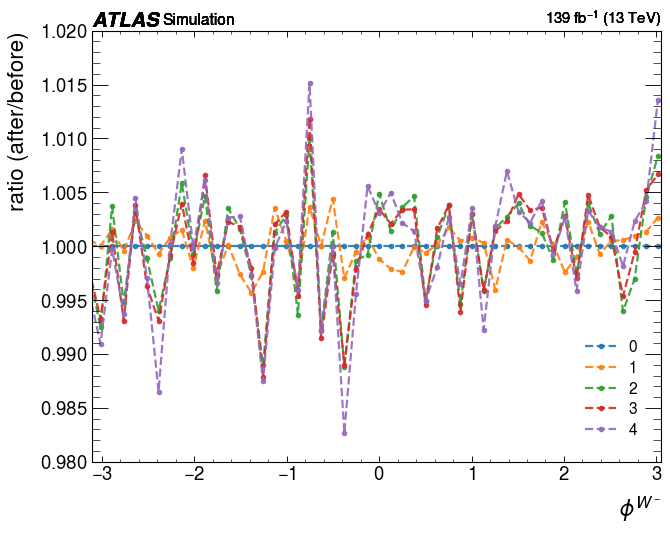

In [14]:
# Wm analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="pt")
    ratio_plot(ratio_data, ylabel=r"$p^{W^-}_{T}$", range=rrange/GEV)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="eta")
    ratio_plot(ratio_data, ylabel=r"$\eta^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="phi")
    ratio_plot(ratio_data, ylabel=r"$\phi^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


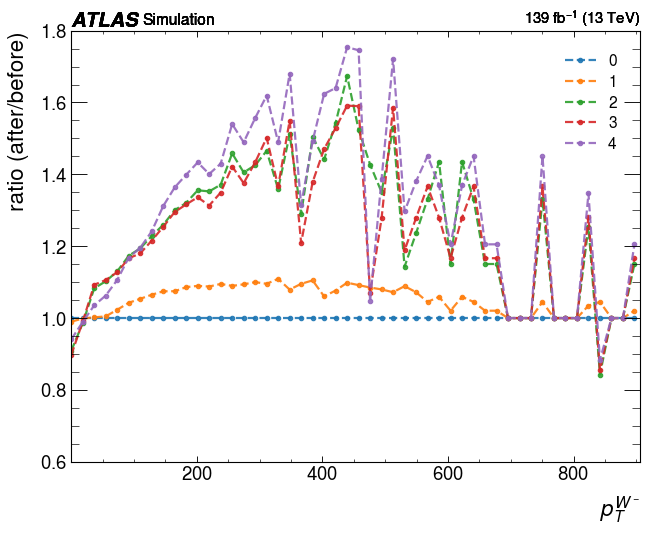

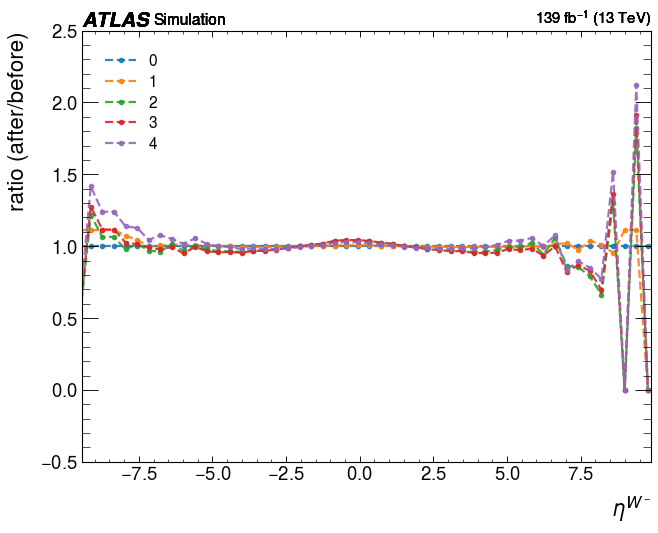

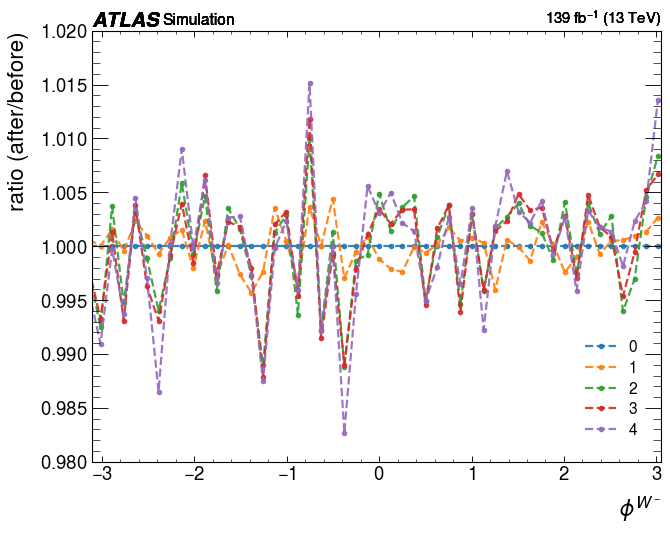

In [15]:
# Wp analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="pt")
    ratio_plot(ratio_data, ylabel=r"$p^{W^-}_{T}$", range=rrange/GEV)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="eta")
    ratio_plot(ratio_data, ylabel=r"$\eta^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="phi")
    ratio_plot(ratio_data, ylabel=r"$\phi^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


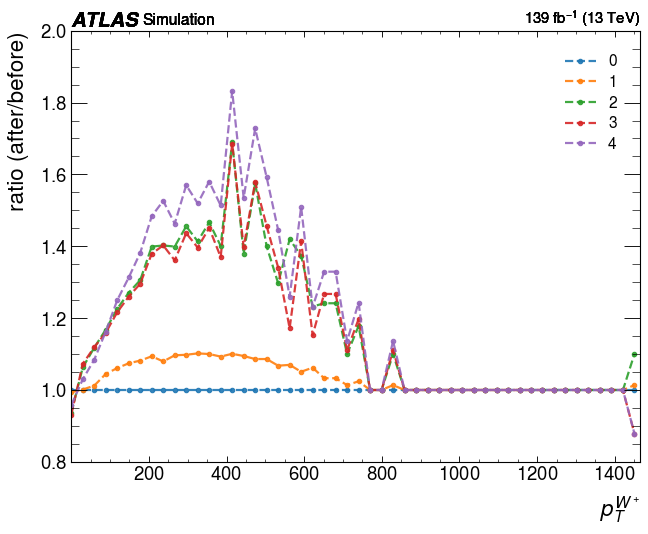

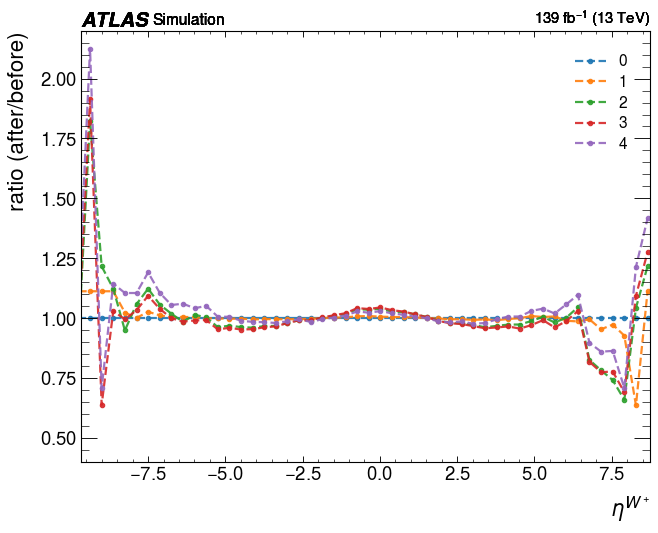

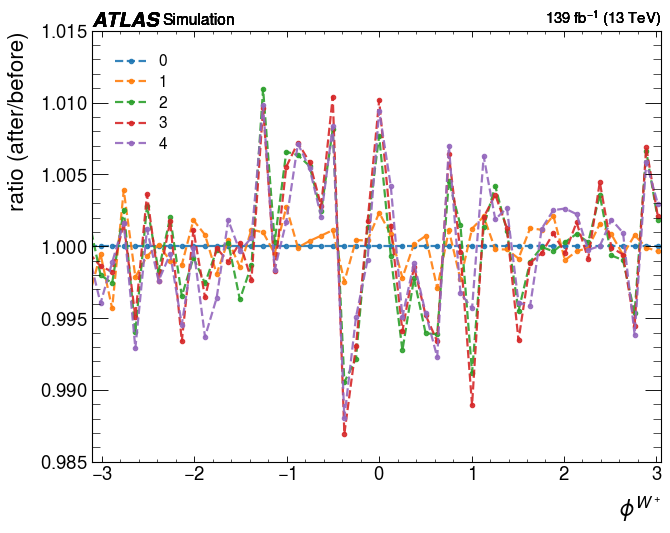

In [16]:
# Wp analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wp, var="pt")
    ratio_plot(ratio_data, ylabel=r"$p^{W^+}_{T}$", range=rrange/GEV)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wp, var="eta")
    ratio_plot(ratio_data, ylabel=r"$\eta^{W^+}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wp, var="phi")
    ratio_plot(ratio_data, ylabel=r"$\phi^{W^+}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


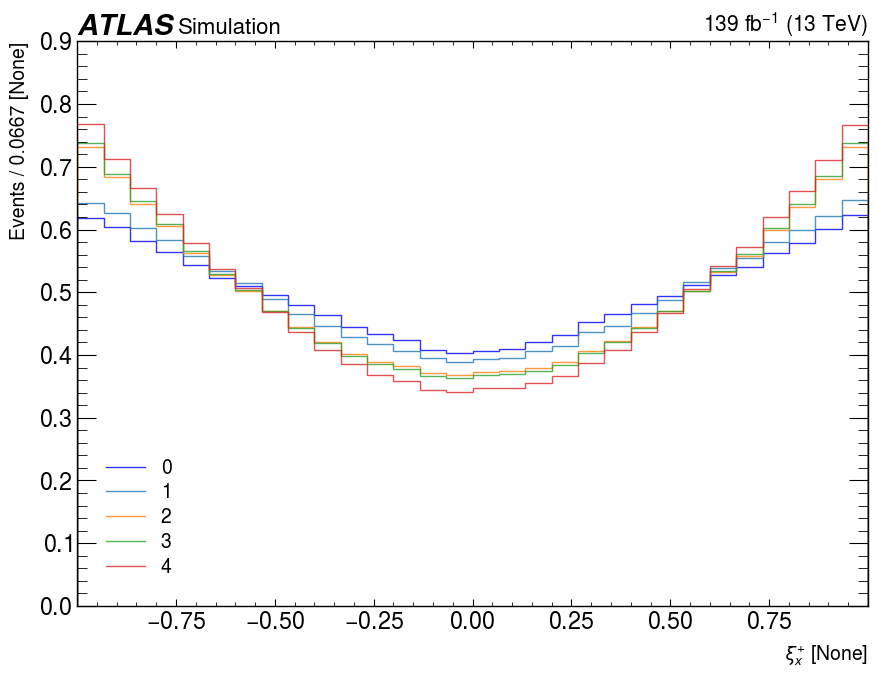

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


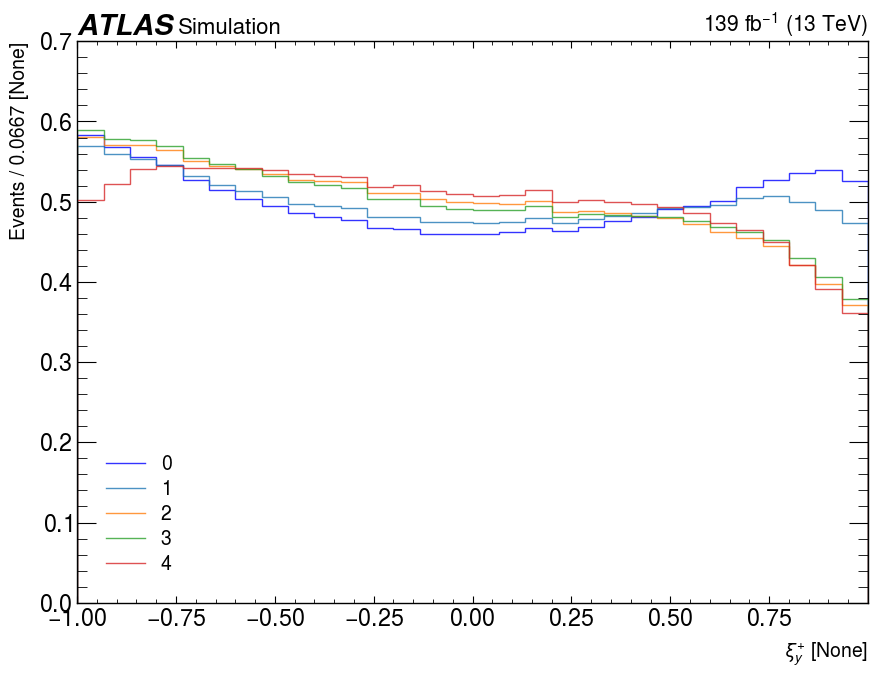

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


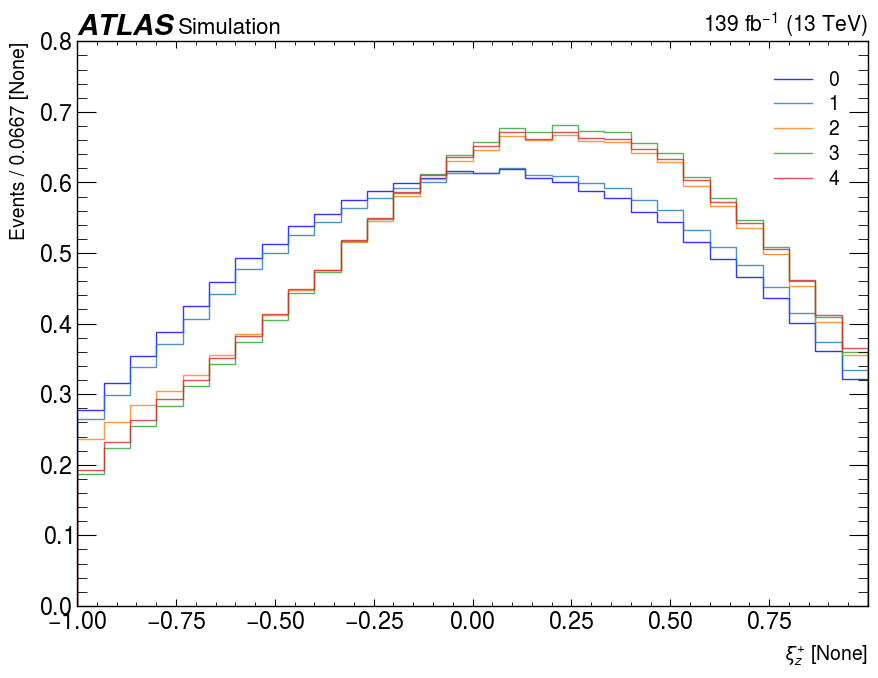

1D, Finish!


In [17]:
# xi_p distribution checking

data = [Xi[CGLMP_analysis(Cuts=cuts[i])]["xi_p_x"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\xi^{+}_{x}$", label=name, loc=0)
data = [Xi[CGLMP_analysis(Cuts=cuts[i])]["xi_p_y"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\xi^{+}_{y}$", label=name, loc=0)
data = [Xi[CGLMP_analysis(Cuts=cuts[i])]["xi_p_z"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\xi^{+}_{z}$", label=name, loc=0)

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


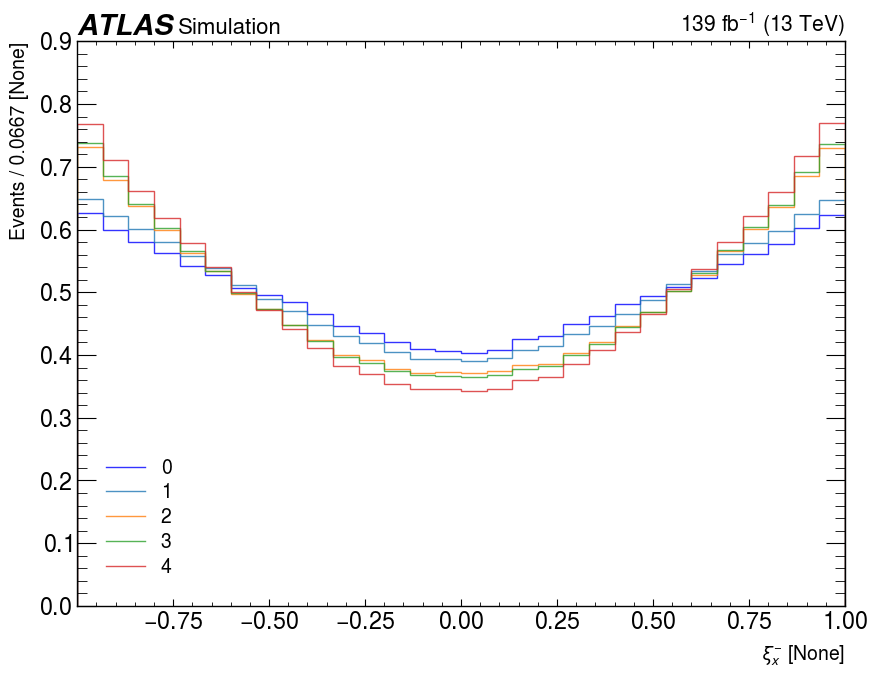

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


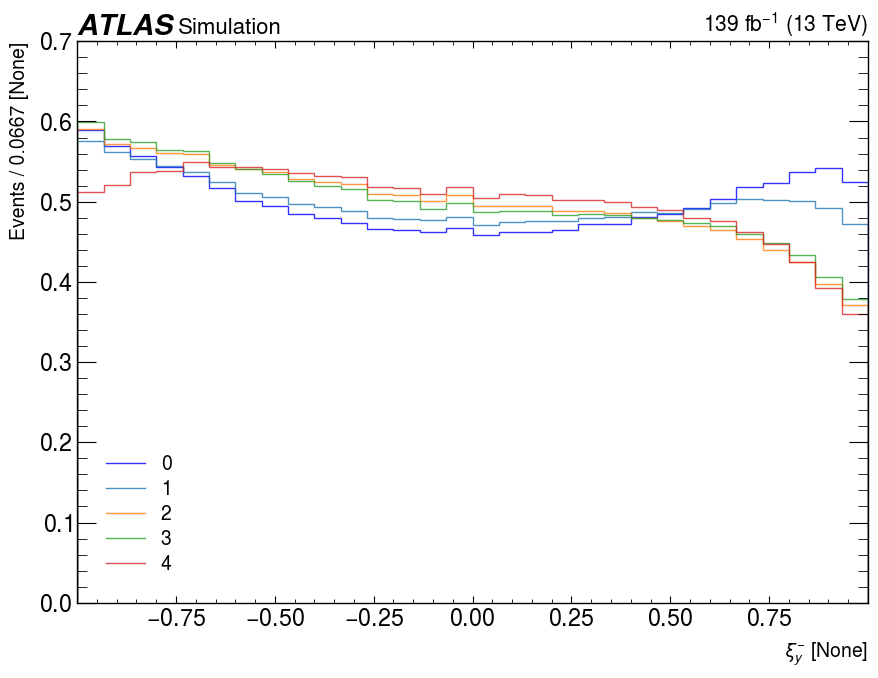

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


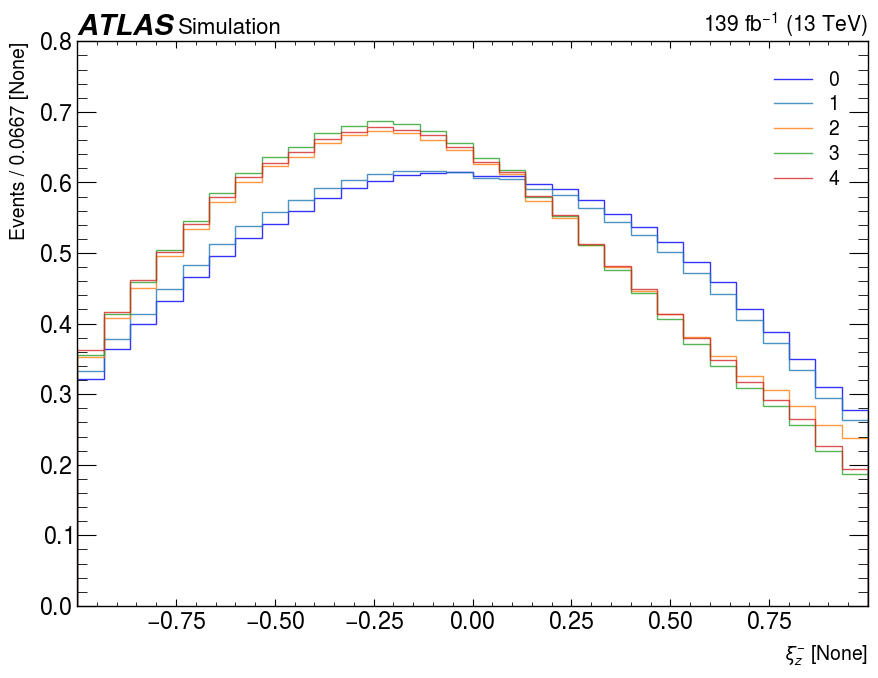

1D, Finish!


In [18]:
# xi_m distribution checking

data = [Xi[CGLMP_analysis(Cuts=cuts[i])]["xi_m_x"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\xi^{-}_{x}$", label=name, loc=0)
data = [Xi[CGLMP_analysis(Cuts=cuts[i])]["xi_m_y"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\xi^{-}_{y}$", label=name, loc=0)
data = [Xi[CGLMP_analysis(Cuts=cuts[i])]["xi_m_z"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\xi^{-}_{z}$", label=name, loc=0)

In [63]:
test_cut = CGLMP_analysis(Cuts=[], show=False)[:HALF_XI]
print(len(Xi_1))
Xi_1[test_cut[:HALF_XI]]["xi_p_x"]

1223985


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


0          0.992103
1         -0.385974
2          0.991712
3         -0.079282
4          0.187569
             ...   
1223980    0.987928
1223981    0.359130
1223982    0.567047
1223983    0.824999
1223984    0.356309
Name: xi_p_x, Length: 1223985, dtype: float64

In [75]:
HALF_XI = int(len(Xi)/2)
Xi_1 = Xi[:HALF_XI]
Xi_2 = Xi[HALF_XI:]

def kl_rel_div(
    Cuts: list = [],
    df: pd.DataFrame = Xi,
    var: str = "xi_p_x",
    show: bool = False,
) -> tuple:
    half_df = int(len(df)/2)
    df_1 = Xi[:half_df]
    df_2 = Xi[half_df:]
    cut = CGLMP_analysis(Cuts=Cuts, show=show)
    min, max = np.min(df[cut][var]), np.max(df[cut][var])
    qk = np.histogram(df_1[cut[:half_df]][var], bins=50, range=[min, max], density=True)
    pk = np.histogram(df_2[cut[half_df:]][var], bins=50, range=[min, max], density=True)
    entropy = stats.entropy(pk[0], qk[0])

    return entropy

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


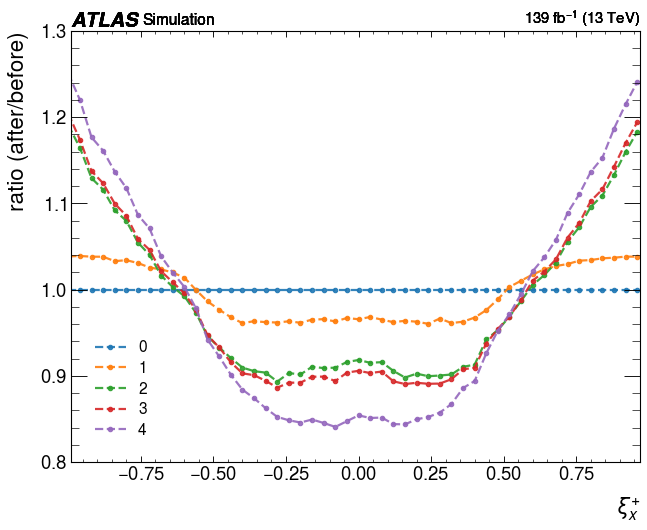

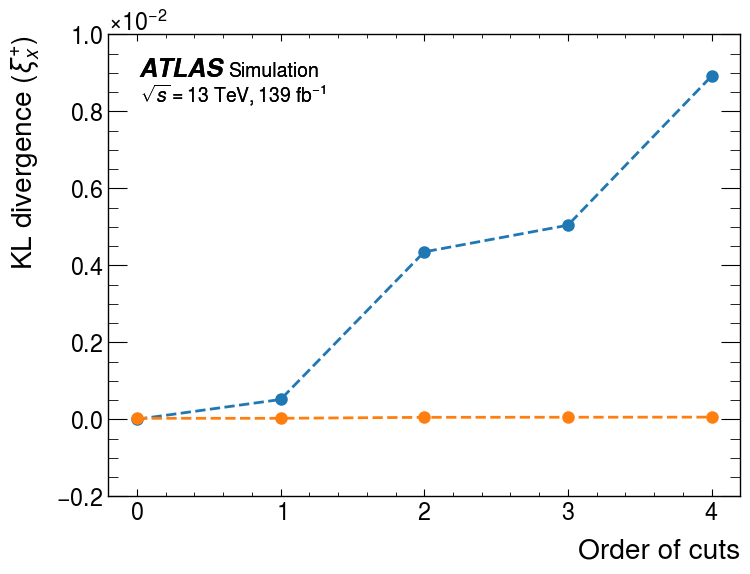

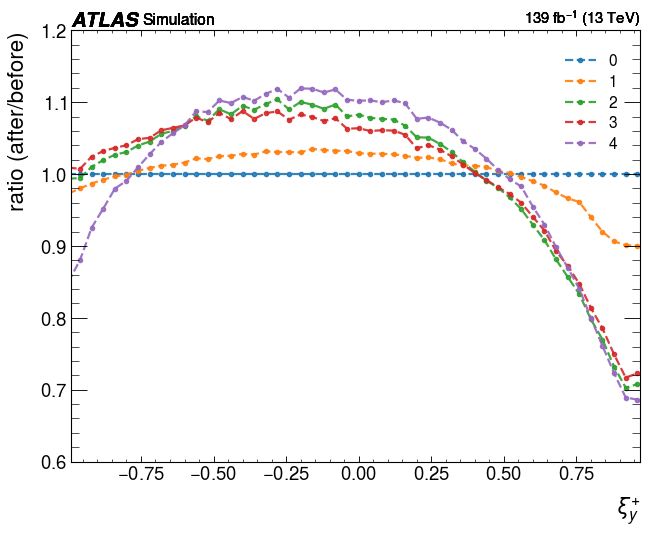

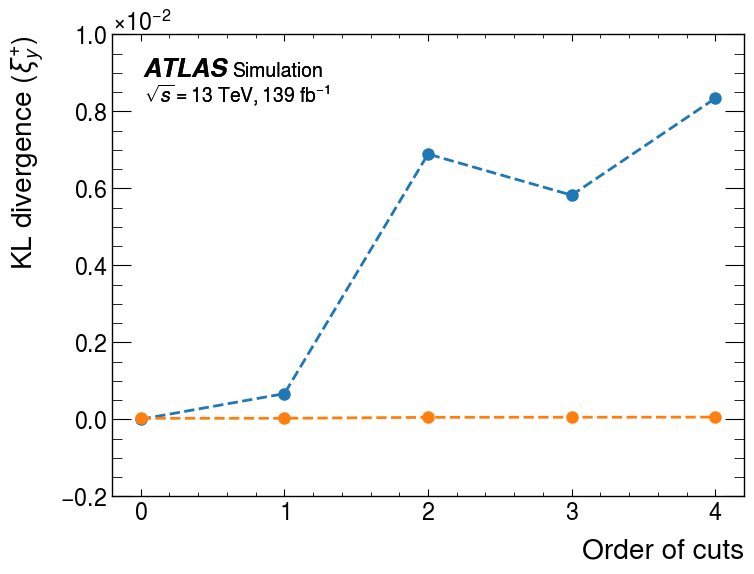

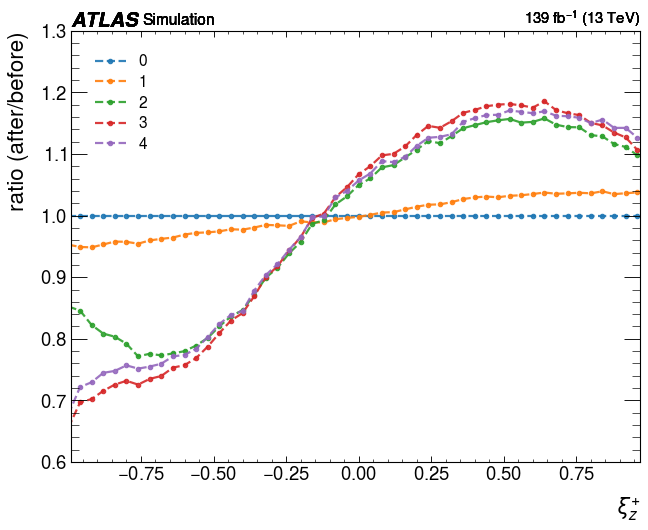

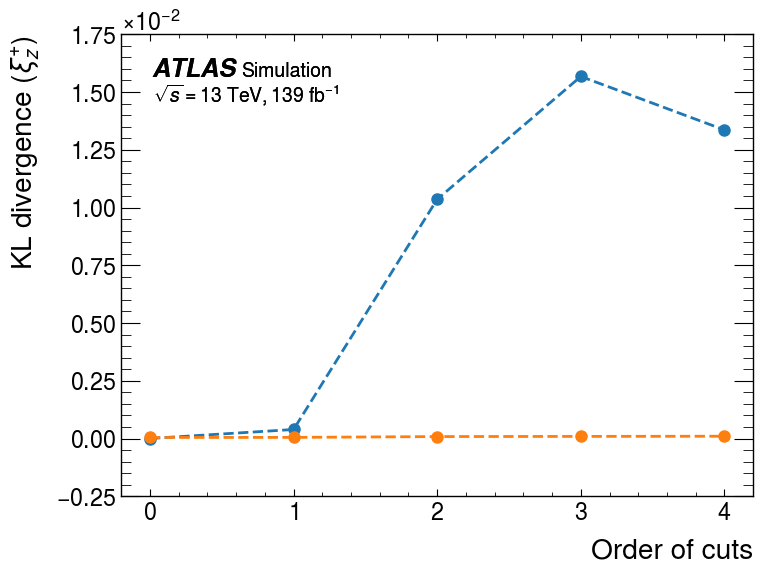

In [78]:
# Xi_p analysis

rel_entro = np.zeros(len(cuts))
sample_kl = np.zeros(len(cuts))
fig = plt.figure(figsize=(9, 7), dpi=80)
num = 0
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_p_x")
    ratio_plot(ratio_data, ylabel=r"$\xi_{x}^{+}$", range=rrange)
    rel_entro[num], _ = kl_div(i, [], df=Xi, var="xi_p_x")
    sample_kl[num] = kl_rel_div(i, var="xi_p_y")
    num += 1
plt.legend(name, loc="best")
plt.show()
plt.close()
kl_plot(rel_entro, ylabel=r"$\xi_{x}^{+}$", range=np.arange(len(cuts)))
kl_plot(sample_kl, ylabel=r"$\xi_{x}^{+}$", range=np.arange(len(cuts)))
plt.show()
plt.close()

rel_entro = np.zeros(len(cuts))
sample_kl = np.zeros(len(cuts))
fig = plt.figure(figsize=(9, 7), dpi=80)
num = 0
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_p_y")
    ratio_plot(ratio_data, ylabel=r"$\xi_{y}^{+}$", range=rrange)
    rel_entro[num], _ = kl_div(i, [], df=Xi, var="xi_p_y")
    sample_kl[num] = kl_rel_div(i, var="xi_p_y")
    num += 1
plt.legend(name, loc="best")
plt.show()
plt.close()
kl_plot(rel_entro, ylabel=r"$\xi_{y}^{+}$", range=np.arange(len(cuts)))
kl_plot(sample_kl, ylabel=r"$\xi_{y}^{+}$", range=np.arange(len(cuts)))
plt.show()
plt.close()

rel_entro = np.zeros(len(cuts))
sample_kl = np.zeros(len(cuts))
fig = plt.figure(figsize=(9, 7), dpi=80)
num = 0
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_p_z")
    ratio_plot(ratio_data, ylabel=r"$\xi_{z}^{+}$", range=rrange)
    rel_entro[num], _ = kl_div(i, [], df=Xi, var="xi_p_z")
    sample_kl[num] = kl_rel_div(i, var="xi_p_z")
    num += 1
plt.legend(name, loc="best")
plt.show()
plt.close()
kl_plot(rel_entro, ylabel=r"$\xi_{z}^{+}$", range=np.arange(len(cuts)))
kl_plot(sample_kl, ylabel=r"$\xi_{z}^{+}$", range=np.arange(len(cuts)))
plt.show()
plt.close()


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


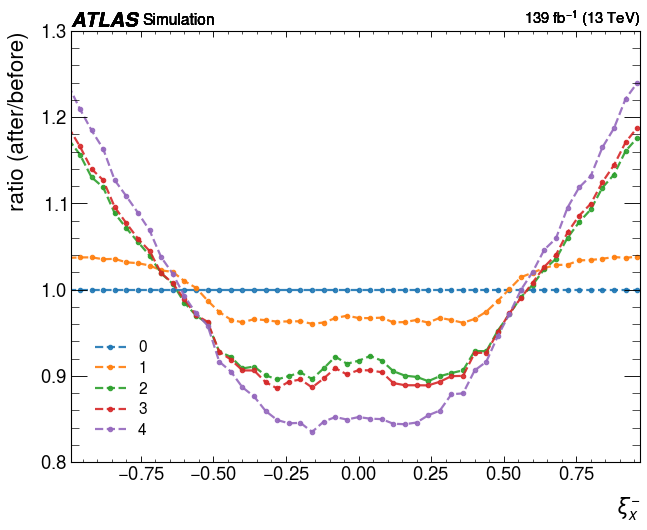

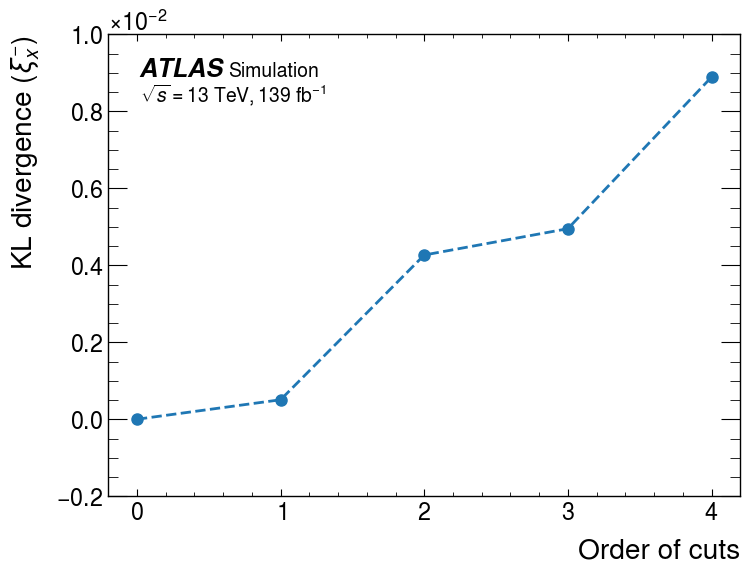

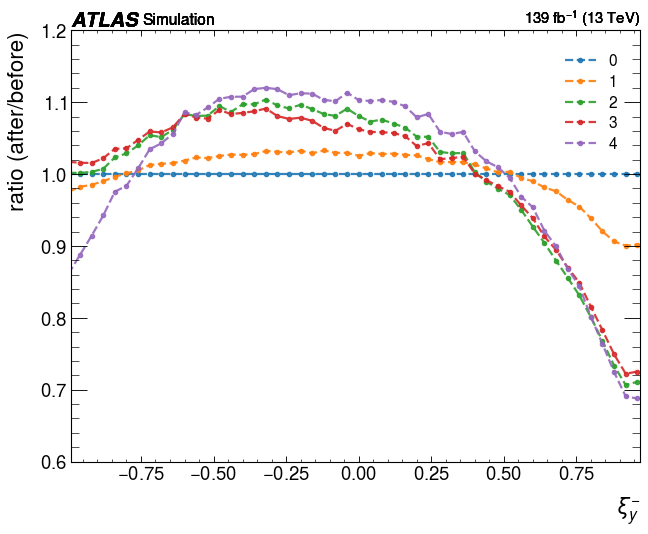

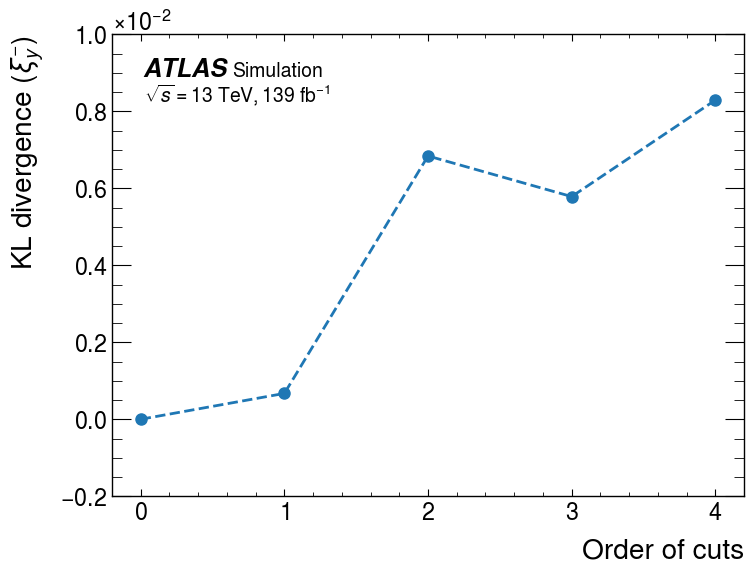

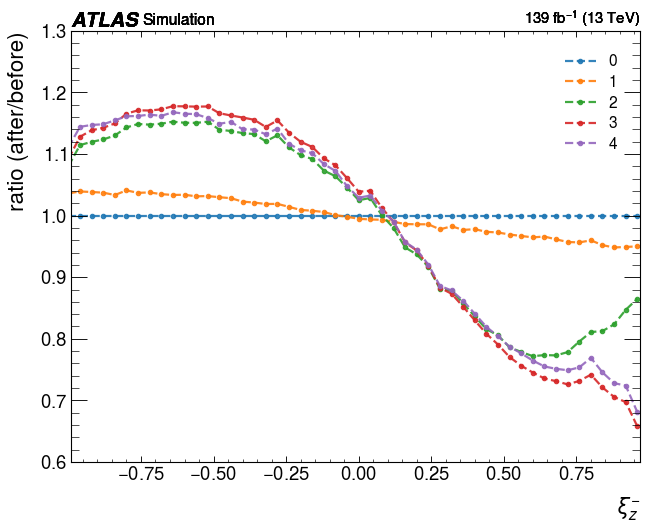

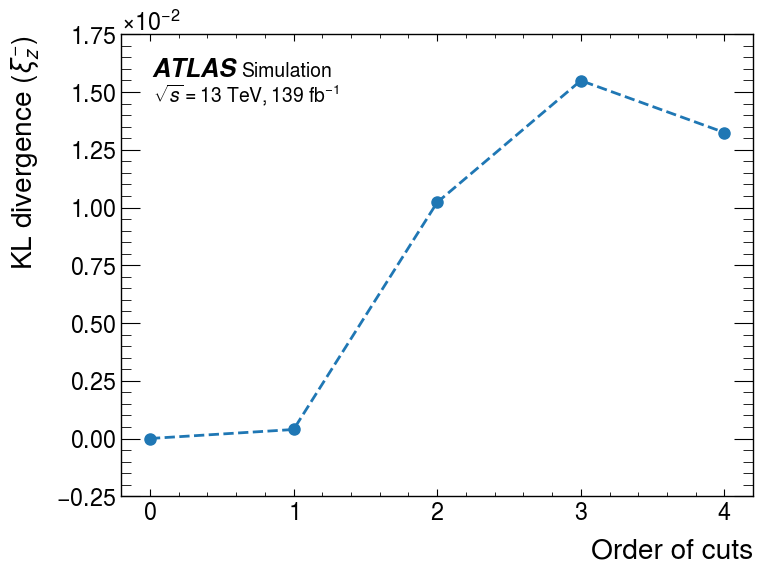

In [21]:
# Xi_m analysis

rel_entro = np.zeros(len(cuts))
fig = plt.figure(figsize=(9, 7), dpi=80)
num = 0
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_m_x")
    ratio_plot(ratio_data, ylabel=r"$\xi_{x}^{-}$", range=rrange)
    rel_entro[num], _ = kl_div(i, [], df=Xi, var="xi_m_x")
    num += 1
plt.legend(name, loc="best")
plt.show()
plt.close()
kl_plot(rel_entro, ylabel=r"$\xi_{x}^{-}$", range=np.arange(len(cuts)))
plt.show()
plt.close()

rel_entro = np.zeros(len(cuts))
fig = plt.figure(figsize=(9, 7), dpi=80)
num = 0
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_m_y")
    ratio_plot(ratio_data, ylabel=r"$\xi_{y}^{-}$", range=rrange)
    rel_entro[num], _ = kl_div(i, [], df=Xi, var="xi_m_y")
    num += 1
plt.legend(name, loc="best")
plt.show()
plt.close()
kl_plot(rel_entro, ylabel=r"$\xi_{y}^{-}$", range=np.arange(len(cuts)))
plt.show()
plt.close()

rel_entro = np.zeros(len(cuts))
fig = plt.figure(figsize=(9, 7), dpi=80)
num = 0
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_m_z")
    ratio_plot(ratio_data, ylabel=r"$\xi_{z}^{-}$", range=rrange)
    rel_entro[num], _ = kl_div(i, [], df=Xi, var="xi_m_z")
    num += 1
plt.legend(name, loc="best")
plt.show()
plt.close()
kl_plot(rel_entro, ylabel=r"$\xi_{z}^{-}$", range=np.arange(len(cuts)))
plt.show()
plt.close()


In [22]:
# CGLMP terms

def term1(xi_p_x, xi_m_x, xi_p_y, xi_m_y):
    return xi_p_x*xi_m_x + xi_p_y*xi_m_y

def term2(xi_p_x, xi_m_x, xi_p_y, xi_m_y):
    return (np.square(xi_p_x) - np.square(xi_p_y))*(np.square(xi_m_x) - np.square(xi_m_y))

def term3(xi_p_x, xi_m_x, xi_p_y, xi_m_y):
    return xi_p_x*xi_p_y*xi_m_x*xi_m_y

In [23]:
term1_xy = term1(Xi["xi_p_x"], Xi["xi_m_x"], Xi["xi_p_y"], Xi["xi_m_y"])
term2_xy = term2(Xi["xi_p_x"], Xi["xi_m_x"], Xi["xi_p_y"], Xi["xi_m_y"])
term3_xy = term3(Xi["xi_p_x"], Xi["xi_m_x"], Xi["xi_p_y"], Xi["xi_m_y"])

term1_yz = term1(Xi["xi_p_y"], Xi["xi_m_y"], Xi["xi_p_z"], Xi["xi_m_z"])
term2_yz = term2(Xi["xi_p_y"], Xi["xi_m_y"], Xi["xi_p_z"], Xi["xi_m_z"])
term3_yz = term3(Xi["xi_p_y"], Xi["xi_m_y"], Xi["xi_p_z"], Xi["xi_m_z"])

term1_zx = term1(Xi["xi_p_z"], Xi["xi_m_z"], Xi["xi_p_x"], Xi["xi_m_x"])
term2_zx = term2(Xi["xi_p_z"], Xi["xi_m_z"], Xi["xi_p_x"], Xi["xi_m_x"])
term3_zx = term3(Xi["xi_p_z"], Xi["xi_m_z"], Xi["xi_p_x"], Xi["xi_m_x"])

df_Xi = pd.DataFrame(
    {
        "term1_xy": term1_xy,
        "term2_xy": term2_xy,
        "term3_xy": term3_xy,
        "term1_yz": term1_yz,
        "term2_yz": term2_yz,
        "term3_yz": term3_yz,
        "term1_zx": term1_zx,
        "term2_zx": term2_zx,
        "term3_zx": term3_zx,
    }
)

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


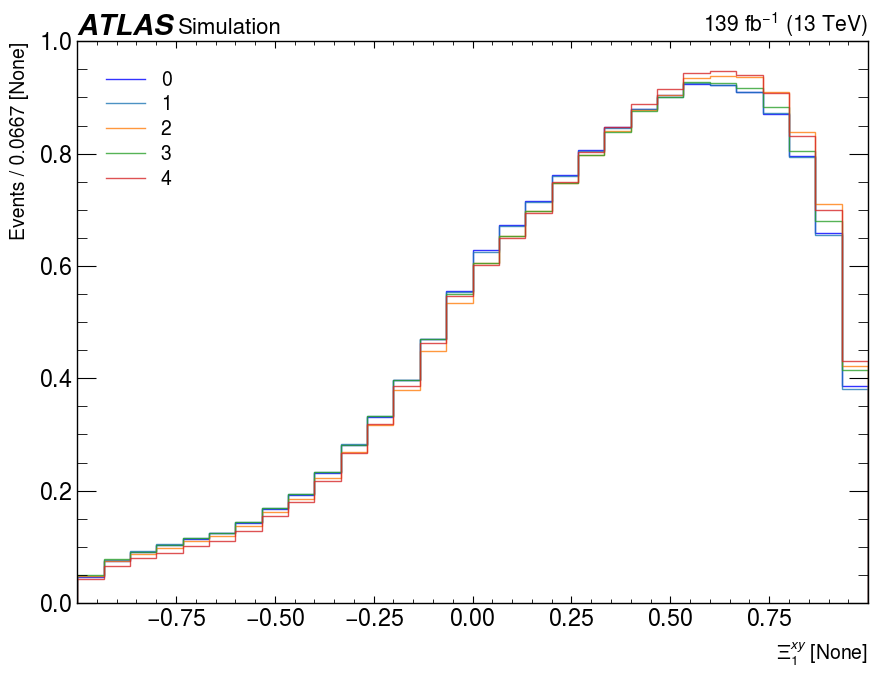

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


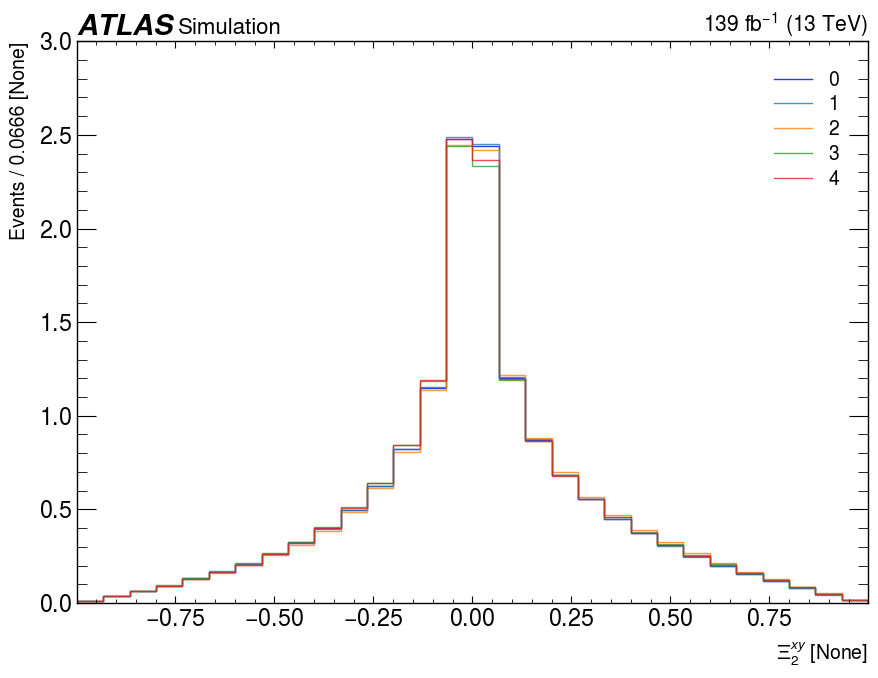

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


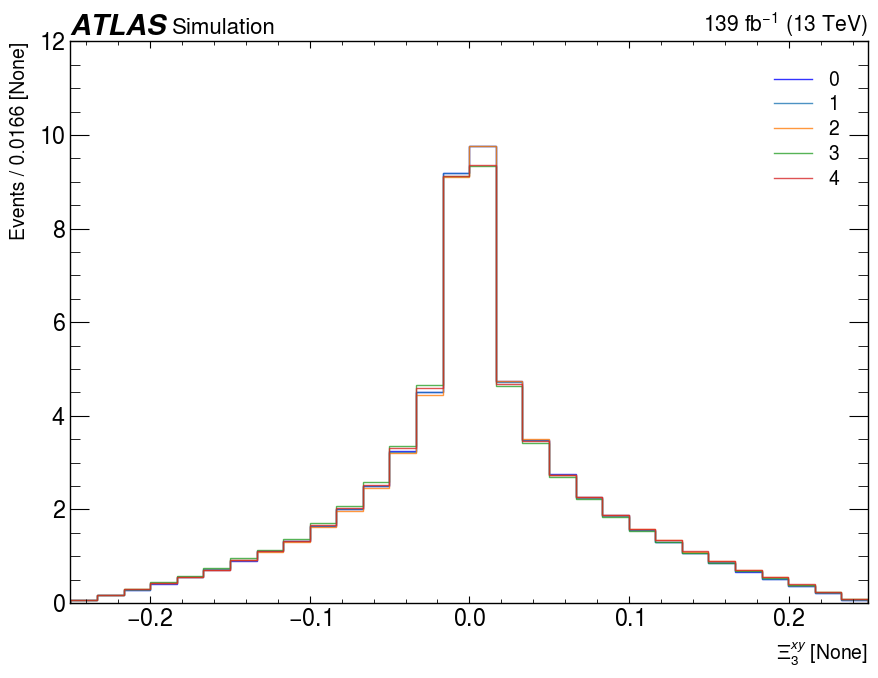

1D, Finish!


In [24]:
# Xi_xy distributions

data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term1_xy"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{xy}_{1}$", label=name, loc=0, unit="None")
data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term2_xy"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{xy}_{2}$", label=name, loc=0, unit="None")
data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term3_xy"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{xy}_{3}$", label=name, loc=0, unit="None")

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


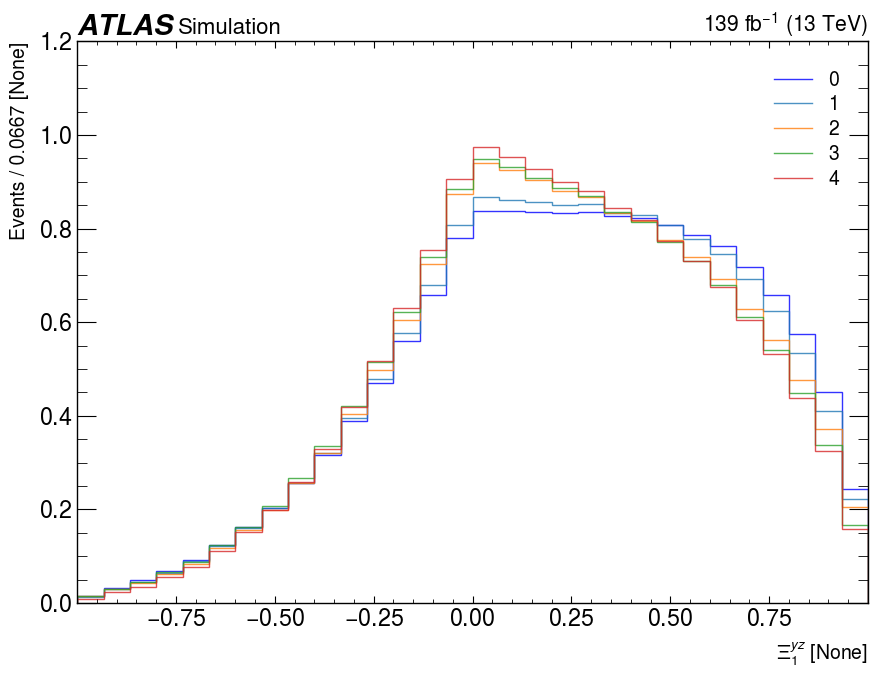

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


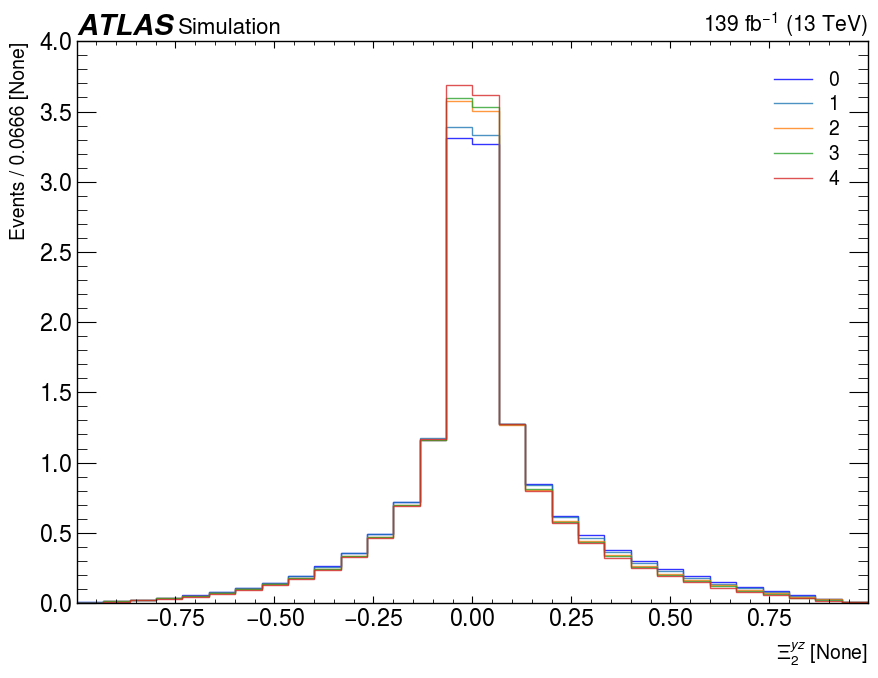

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


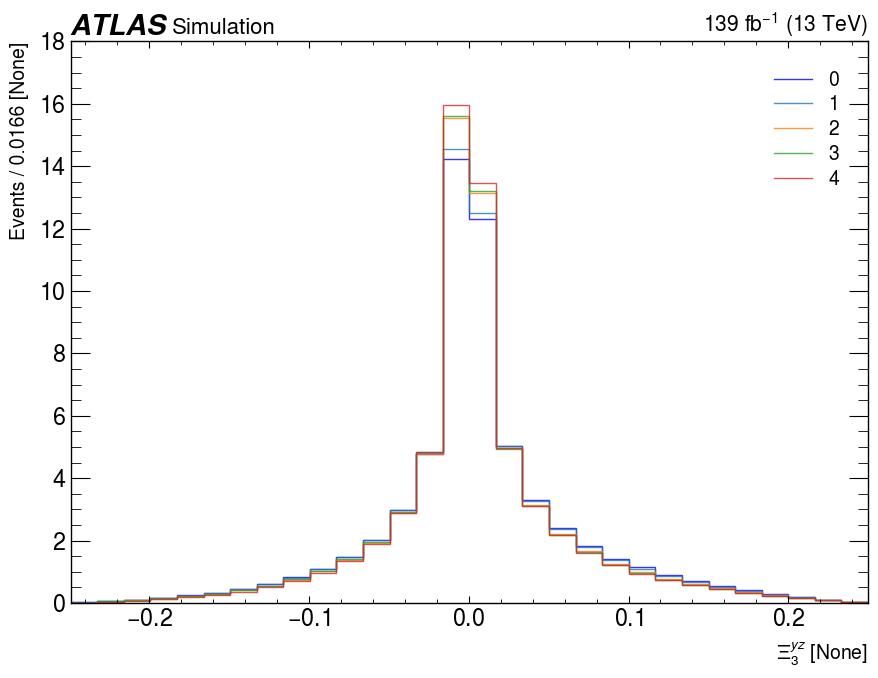

1D, Finish!


In [25]:
# Xi_yz distributions

data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term1_yz"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{yz}_{1}$", label=name, loc=0, unit="None")
data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term2_yz"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{yz}_{2}$", label=name, loc=0, unit="None")
data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term3_yz"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{yz}_{3}$", label=name, loc=0, unit="None")

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


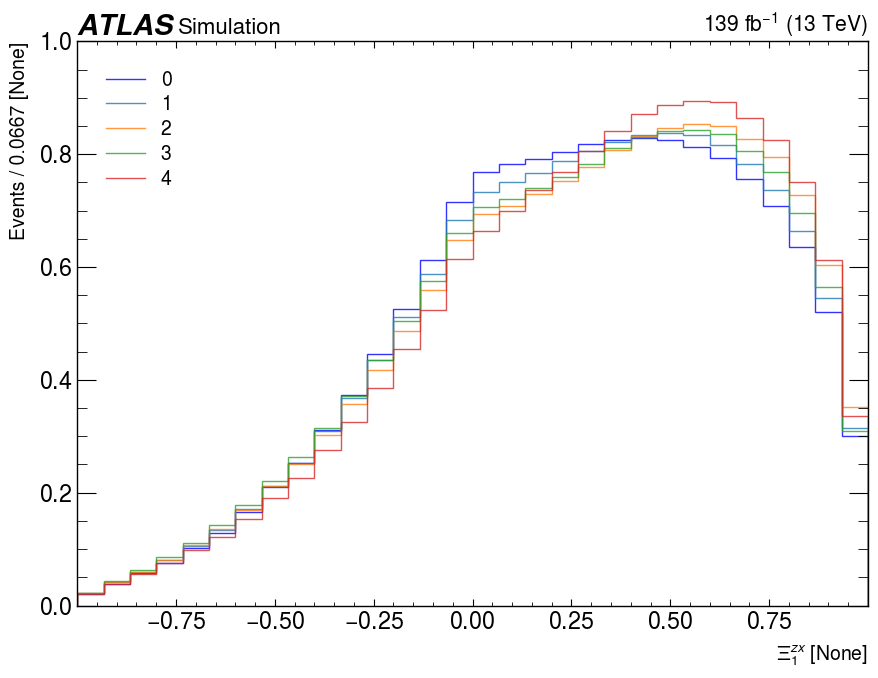

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


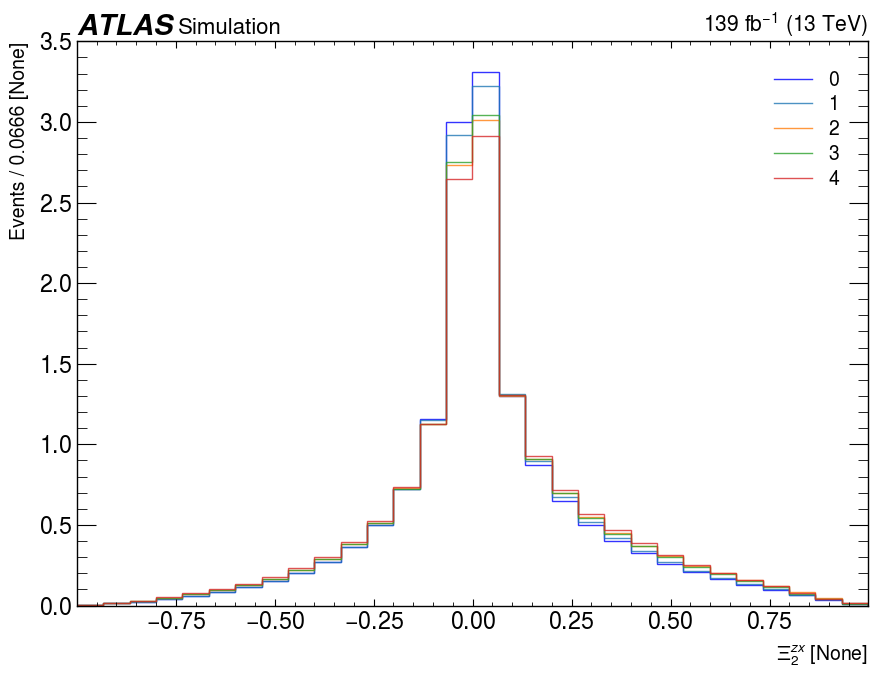

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


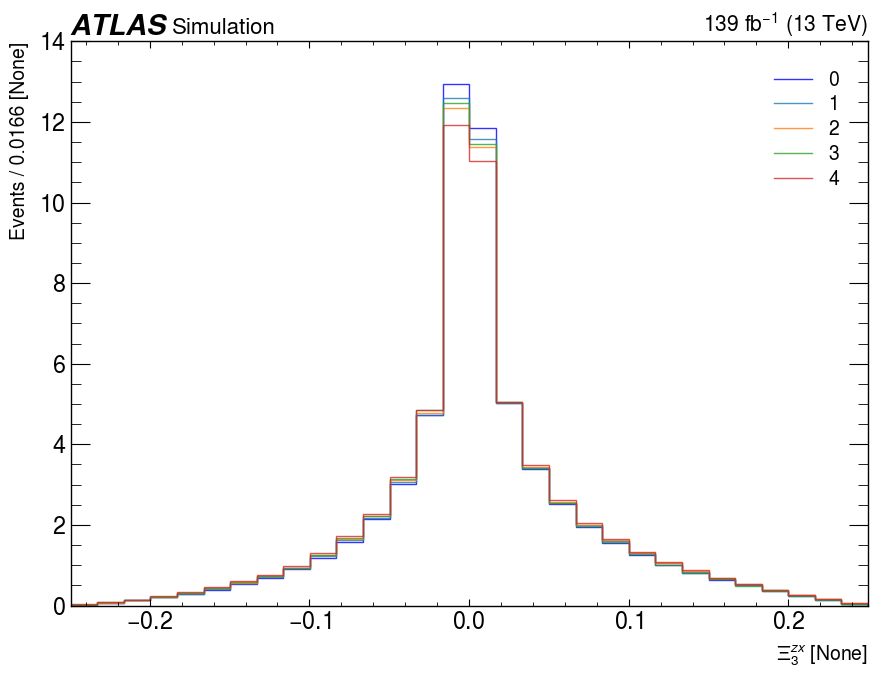

1D, Finish!


In [26]:
# Xi_zx distributions

data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term1_zx"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{zx}_{1}$", label=name, loc=0, unit="None")
data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term2_zx"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{zx}_{2}$", label=name, loc=0, unit="None")
data = [df_Xi[CGLMP_analysis(Cuts=cuts[i])]["term3_zx"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{zx}_{3}$", label=name, loc=0, unit="None")

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


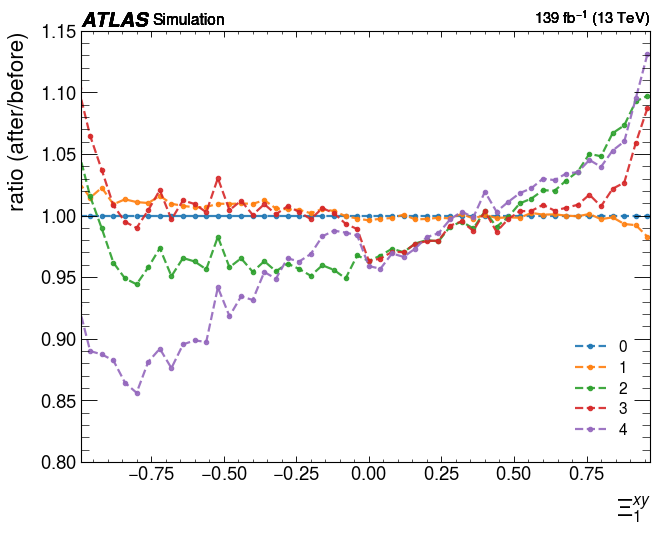

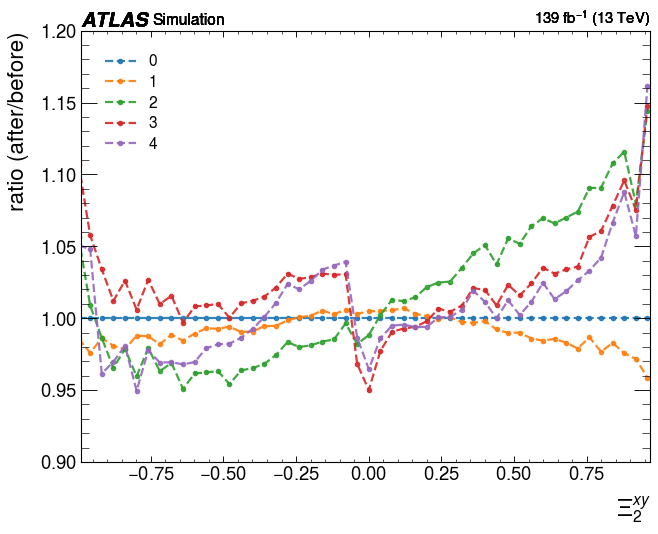

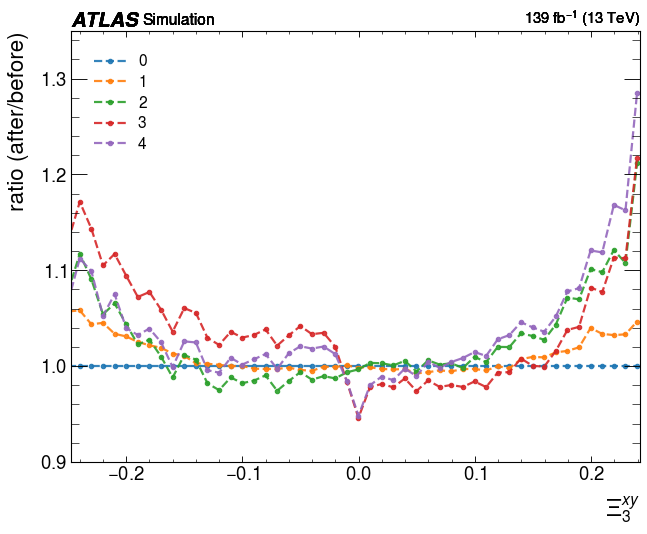

In [27]:
# term_xy analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term1_xy")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{xy}_{1}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term2_xy")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{xy}_{2}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term3_xy")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{xy}_{3}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


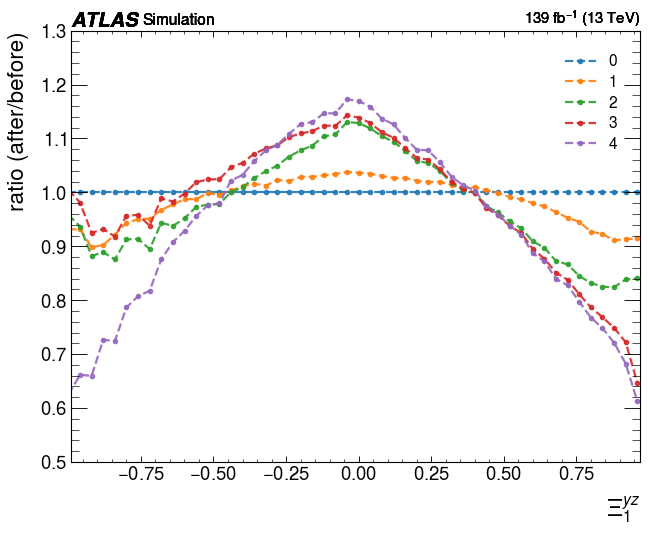

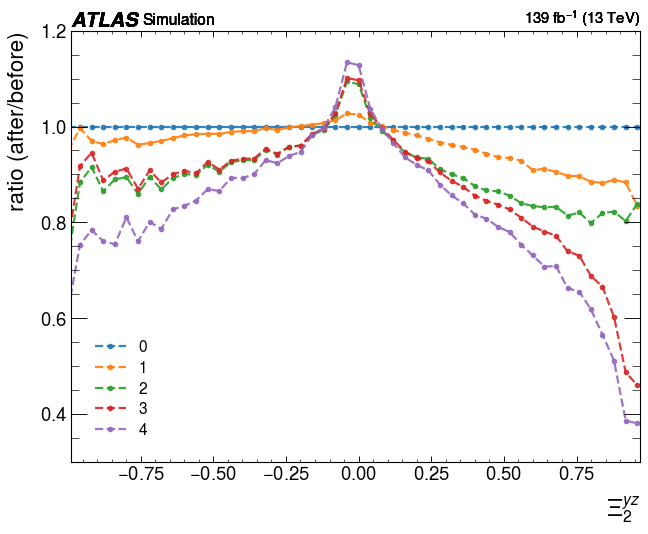

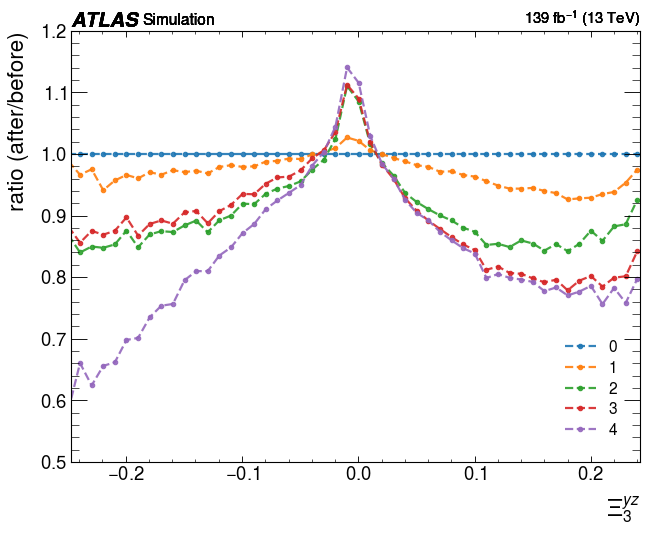

In [28]:
# term_yz analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term1_yz")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{yz}_{1}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term2_yz")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{yz}_{2}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term3_yz")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{yz}_{3}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


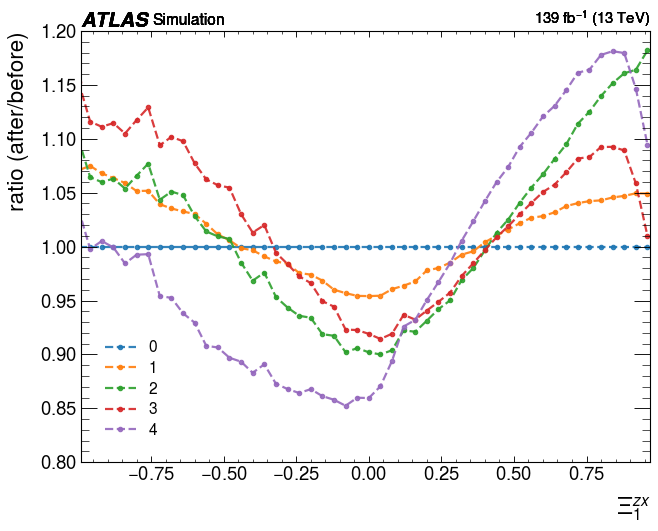

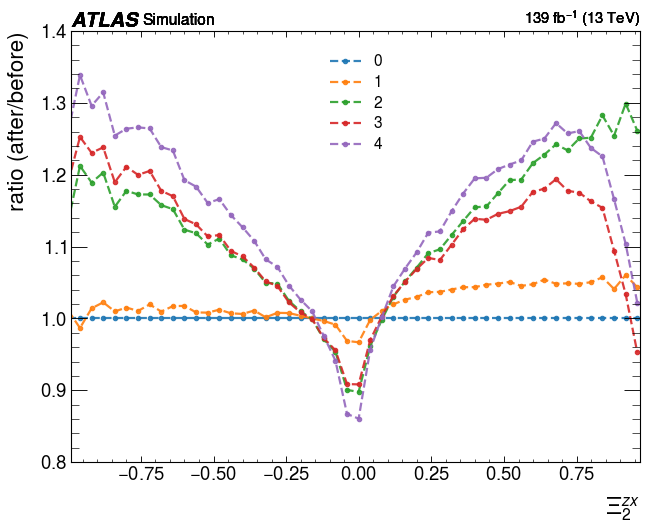

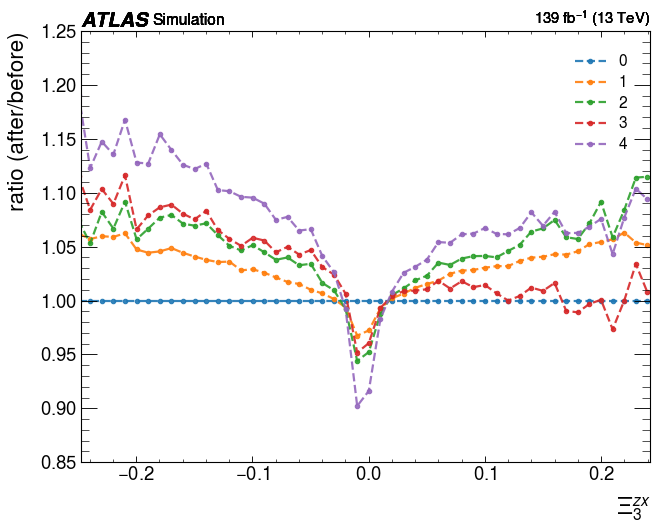

In [29]:
# term_zx analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term1_zx")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{zx}_{1}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term2_zx")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{zx}_{2}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df_Xi, var="term3_zx")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{zx}_{3}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

In [30]:
# fig = plt.figure(figsize=(9, 7), dpi=80)
# for i in cuts:
#     ratio_data = ratio(i, [], df=SubLep, var="pt")
#     ratio_plot(ratio_data, ylabel=r"$p^{SubLead}_{T}$ [GeV]")
# plt.xlim(-2, 32)
# plt.legend(name, loc="best")
# plt.show()

In [31]:
# fig = plt.figure(figsize=(9, 7), dpi=80)
# for i, j in zip(cuts, name):
#     ratio_data = ratio(i, [], df=MET, var="pt")
#     ratio_plot(ratio_data, ylabel=r"$p^{miss}_{T}$ [GeV]")
# plt.xlim(-2, 32)
# plt.legend(name, loc="best")
# plt.show()

In [32]:
# fig = plt.figure(figsize=(9, 7), dpi=80)
# for i, j in zip(cuts, name):
#     ratio_data = ratio(i, [], df=diLep, var="m")
#     ratio_plot(ratio_data, ylabel=r"$m_{ll}$ [GeV]")
# plt.xlim(-2, 32)
# plt.legend(name, loc="best")
# plt.show()

In [33]:
# CGLMP values analysis

all_cuts = [[], *cuts]
all_name = ["0", *name]
for i, j in zip(all_name, all_cuts):
    CGLMP_analysis(CutName=i, Cuts=j, show=True)

# 0
Bxy = 2.210
Bxz = 2.735
Byz = 2.491
-> I3 = 2.735

# 0
Bxy = 2.210
Bxz = 2.735
Byz = 2.491
-> I3 = 2.735

# 1
Bxy = 2.193
Bxz = 2.877
Byz = 2.300
-> I3 = 2.877

# 2
Bxy = 2.542
Bxz = 3.094
Byz = 2.117
-> I3 = 3.094

# 3
Bxy = 2.106
Bxz = 2.851
Byz = 1.890
-> I3 = 2.851

# 4
Bxy = 2.364
Bxz = 3.110
Byz = 1.964
-> I3 = 3.110



/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


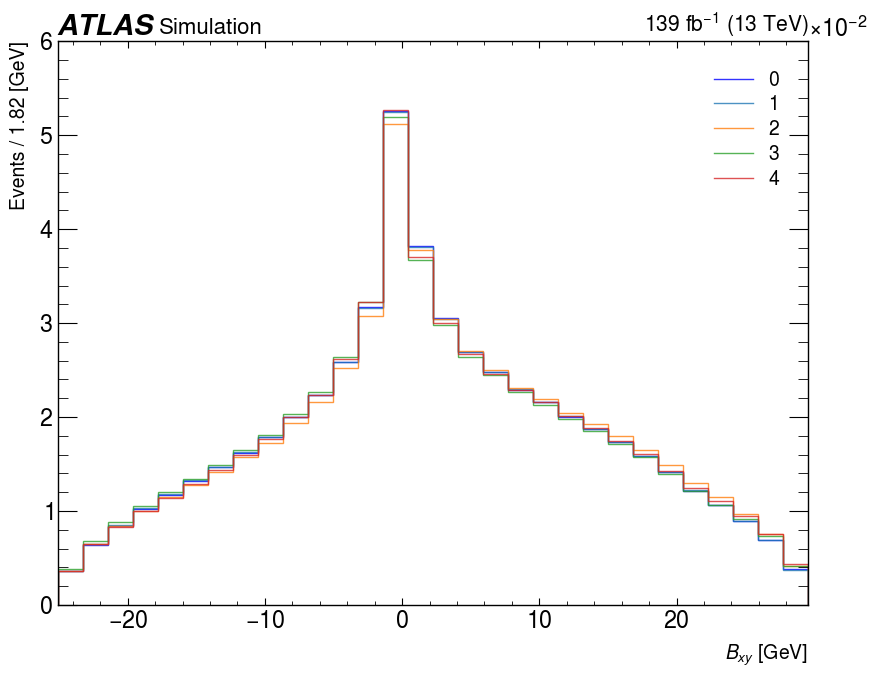

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


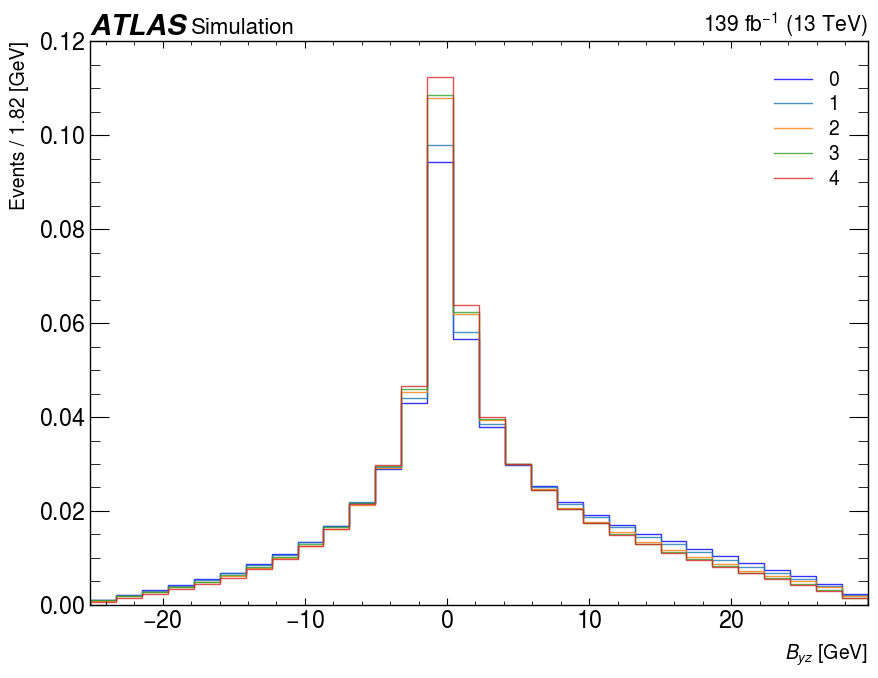

1D, Finish!


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...


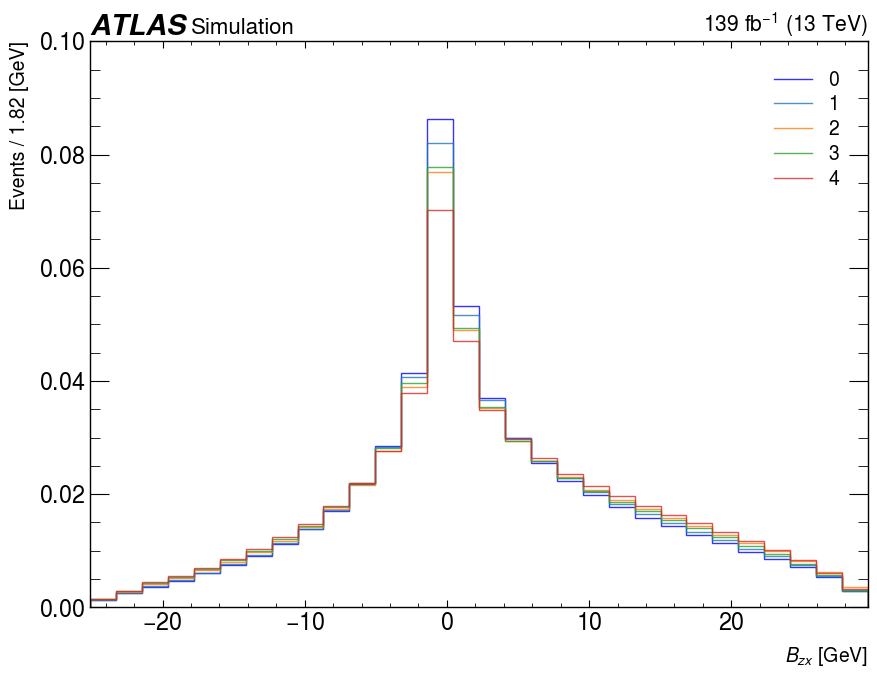

1D, Finish!


In [34]:
data = [CGLMP[CGLMP_analysis(Cuts=cuts[i])]["Bxy"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$B_{xy}$", label=name, loc=0, unit="GeV")
data = [CGLMP[CGLMP_analysis(Cuts=cuts[i])]["Byz"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$B_{yz}$", label=name, loc=0, unit="GeV")
data = [CGLMP[CGLMP_analysis(Cuts=cuts[i])]["Bzx"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$B_{zx}$", label=name, loc=0, unit="GeV")

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_43818/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


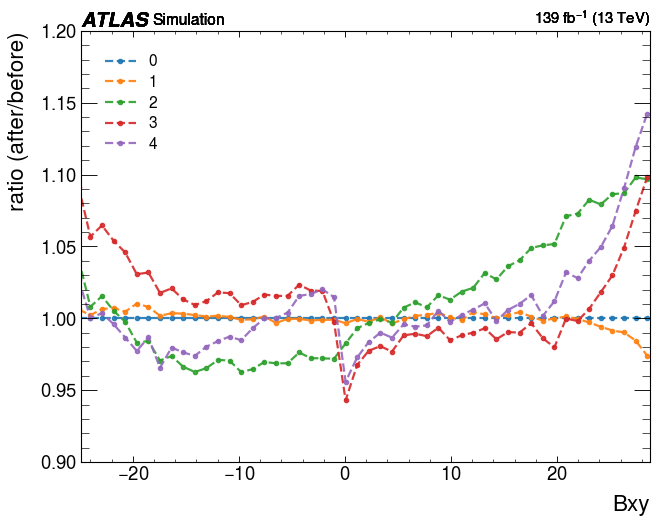

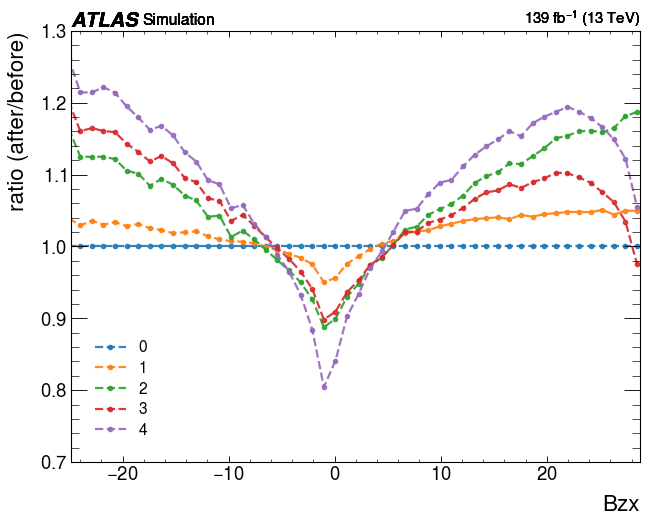

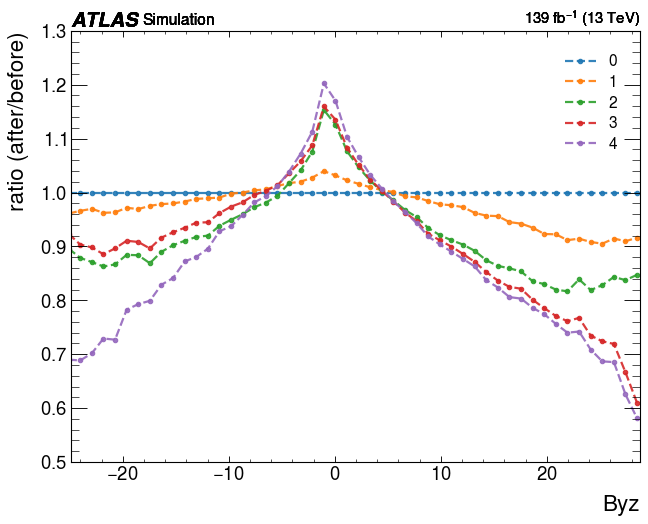

In [35]:
# CGLMP cuts analysis

for var in ["Bxy", "Bzx", "Byz"]:
    fig = plt.figure(figsize=(9, 7), dpi=80)
    for i, j in zip(cuts, name):
        ratio_data, rrange = ratio(i, [], df=CGLMP, var=var)
        ratio_plot(ratio_data, ylabel=var, range=rrange)
    plt.legend(name, loc="best")
    plt.show()

### Correlation study

In [36]:
def corr_matrix(df: pd.DataFrame, title: str, barrange=[-0.1, 1]) -> None:
    corr_matrix = df.corr()
    plt.style.use("default")
    _, ax = plt.subplots(figsize=(15, 15), dpi=120)
    im = ax.imshow(corr_matrix.values, cmap="Blues", vmin=barrange[0], vmax=barrange[1])
    ax.set_xticks(np.arange(len(corr_matrix.columns)))
    ax.set_yticks(np.arange(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns)
    ax.set_yticklabels(corr_matrix.columns)
    # rotate tick labels
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=10,
    )
    plt.setp(ax.get_yticklabels(), fontsize=10)
    cbar = ax.figure.colorbar(im, ax=ax, shrink=0.85)
    cbar.ax.tick_params(labelsize=10)
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            ax.text(
                j,
                i,
                round(corr_matrix.values[i, j], 2),
                ha="center",
                va="center",
                color="w",
            )
    ax.set_title(f"Correlation Matrix ({title})", fontsize=14)
    # add black lines to separate blocks
    for n in range(6):
        ax.axvline(x=3.5 + 4 * n, color="grey", linewidth=1)
        ax.axhline(y=3.5 + 4 * n, color="grey", linewidth=1)

    plt.show()
    plt.close()

    return


In [37]:
df = pd.DataFrame(
    {
        "LeadLep_px": LeadLep["px"],
        "LeadLep_py": LeadLep["py"],
        "LeadLep_pz": LeadLep["pz"],
        "LeadLep_E": LeadLep["E"],
        "SubLep_px": SubLep["px"],
        "SubLep_py": SubLep["py"],
        "SubLep_pz": SubLep["pz"],
        "SubLep_E": SubLep["E"],
        "LmNu_px": LmNu["px"],
        "LmNu_py": LmNu["py"],
        "LmNu_pz": LmNu["pz"],
        "LmNu_E": LmNu["E"],
        "LpNu_px": LpNu["px"],
        "LpNu_py": LpNu["py"],
        "LpNu_pz": LpNu["pz"],
        "LpNu_E": LpNu["E"],
        "Wp_px": Wp["px"],
        "Wp_py": Wp["py"],
        "Wp_pz": Wp["pz"],
        "Wp_E": Wp["E"],
        "Wm_px": Wm["px"],
        "Wm_py": Wm["py"],
        "Wm_pz": Wm["pz"],
        "Wz_E": Wm["E"],
        "Higgs_px": Higgs["px"],
        "Higgs_py": Higgs["py"],
        "Higgs_pz": Higgs["pz"],
        "Higgs_E": Higgs["E"],
    }
)

In [38]:
# for i, j in zip(cuts, name):
#     cut_data = df[CGLMP_analysis(Cuts=i)] / GEV
#     corr_matrix(cut_data, j)